# Raccoon deconvolution

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
plt.rc("text", usetex=True)
plt.rc('font', family='serif', size=14)

In [2]:
from tramp.models import MultiLayerModel
from tramp.variables import SIMOVariable, MILeafVariable, SISOVariable as V, SILeafVariable as O
from tramp.channels import Blur2DChannel, GaussianChannel, GradientChannel
from tramp.priors import BinaryPrior, GaussianPrior, GaussBernouilliPrior
from tramp.experiments import TeacherStudentScenario

In [3]:
def plot_data(x_true, y, x_pred):
    fig, axs = plt.subplots(1,3,figsize=(9,3))
    axs[0].imshow(x_true["x"], cmap="gray")
    axs[0].set(title=r"x true")
    axs[1].imshow(y, cmap="gray")
    axs[1].set(title=r"y")
    axs[2].imshow(x_pred["x"], cmap="gray")
    axs[2].set(title="x pred")
    fig.tight_layout()
    
def compare_hcut(x_true, x_pred, h=20):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=False)
    axs[0].plot(x_true["x"][:,h], label="true")
    axs[0].plot(x_pred["x"][:,h], label="pred")
    axs[0].legend()
    axs[0].set(title=r"$x$")
    axs[1].plot(x_true["z"][:,h], label="true")
    axs[1].plot(x_pred["z"][:,h], label="pred")
    axs[1].legend()
    axs[1].set(title=r"$g\ast x$")
    fig.tight_layout()

## Teacher

In [4]:
from scipy.misc import face
from tramp.priors.base_prior import Prior

class CoonPrior(Prior):
    def __init__(self):
        x = face(gray=True).astype(np.float32)
        x = (x - x.mean())/x.std()
        self.x = x
        self.size = x.shape
    def math(self):
        return "coon"
    def sample(self):
        return self.x 

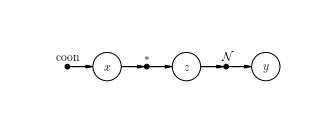

In [5]:
coon = CoonPrior()
x_shape = coon.size
blur = Blur2DChannel(shape=x_shape, sigma=[10, 10])
noise = GaussianChannel(var=0.1)
teacher = MultiLayerModel([coon, blur, noise], ids=["x", "z", "y"])
teacher.plot()

## Basic gaussian denoiser

We use only a gaussian prior on $x$ (the coon image was standardized to have mean=0 and std=1)

In [6]:
# basic deconv model
prior = GaussianPrior(size=x_shape)
basic_deconv = MultiLayerModel(
    [prior, blur, noise], ids=["x","z","y"]
)

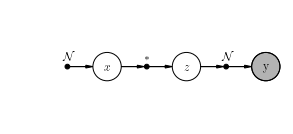

In [7]:
scenario = TeacherStudentScenario(teacher, basic_deconv, x_ids=["x", "z"])
scenario.setup(seed=1)
scenario.student.plot()

In [8]:
_ = scenario.run_ep(max_iter=100, damping=0)

INFO:tramp.algos.message_passing:init message dag with ConstantInit(a=0,b=0)
INFO:tramp.algos.message_passing:no damping
INFO:tramp.algos.callbacks:early stopping all tolerances (on r) are below tol=1.00e-06
INFO:tramp.algos.message_passing:terminated after n_iter=3 iterations


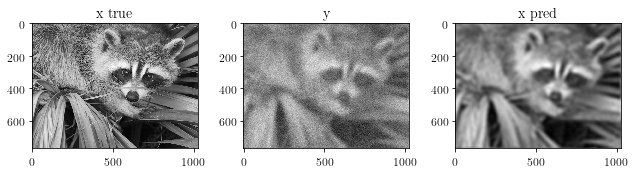

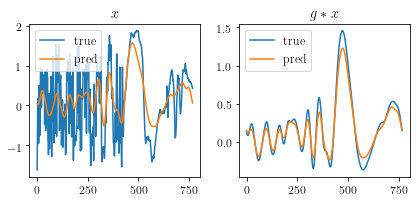

In [9]:
plot_data(scenario.x_true, scenario.observations["y"], scenario.x_pred)
compare_hcut(scenario.x_true, scenario.x_pred)